# Harmonic boundary problem solver for boundaries of arbitrary shape

We are studying the propagation of uncertainty from boundary conditions to (magnetic) field solutions within that boundary. Our initial solution (circular.ipynb) worked exclusively with circular boundaries. 

Now we will attempt to generalise to boundaries of shapes that are *contraction maps*$^1$ of the circle, i.e. single-valued functions of the form $r(\theta)$ such that that the circle is $r(\theta) = r_\text{max} =: \max_\theta r(\theta)$. These curves include the square, ellipse and non-convex curves such that any ray from the origin still intersects the curve just once.

Because the solution interior to the circle is 
$$u(r, \theta) = \sum_{n=0}^\infty r^n \left[a_n \cos(n\theta) + b_n\sin(n\theta)\right]$$
given the Dirichlet condition $u(r_\text{max},\theta):=f(\theta)$ from which $\{a_n, b_n\} = \int f(\theta)\{\cos, \sin\} n\theta d\theta$, the contracted boundary condition $\check{f}(\theta)$ on the curve $\mathscr{C} := r(\theta)$ can be written
$$\check{f}(\theta):=u(r(\theta), \theta) = \sum_{n=0}^\infty \left[r(\theta)\right]^n \left[a_n \cos(n\theta) + b_n\sin(n\theta)\right],$$
noting that $a_n$ and $b_n$ are un-čhecked and so refer to the circle boundary $f(\theta)$.

Because we are provided only with the condition $\check{f}$ on $\mathscr{C}$, we want to be able to write $\{a_n,b_n\}$ in terms of their equivalent coefficients from the contracted boundary condition. Certainly for a concentric *circle* $\mathscr{C}:=r_\text{int}$ we have identically $a_n = \left(\frac{r_\text{int}}{r_\text{max}}\right)^n\check{a}_n$, i.e. by equating the solution for $\check{u}$ to the solution for $u$ on $\mathscr{C}$, and so we hypothesise that for $\mathscr{C} := r(\theta)$ we have
$$\check{u}(r, \theta) = \sum_{n=0}^\infty r^n \left(\frac{r(\theta)}{r_\text{max}}\right)^n\left[\check{a}_n \cos(n\theta) + \check{b}_n\sin(n\theta)\right].$$

Geometrically this implies reconstructing the bounding circle condition $f$ from $\check{f}$ by scaling the Fourier coefficients $\check{a}_n$ and $\check{b}_n$ as above, and then using the Laplace solution for the circular boundary. We should expect this solution to be valid only within $\mathscr{C}$ and not within the entire bounding circle.

**Notes**
1. A contraction mapping of the circle (or rather, the disc) includes boundary curves that don't fit the definition of having any ray from the origin intersect the curve exactly once. The author does not know the name for the kind of mapping described here.

## Comparison to the known solution for a circular contraction

This is an almost trivial starting case, because we know that a boundary value $\check{f}$ on the circular contraction with $r(\theta) = r_\text{int}$ can be scaled back to the boundary $f$ with a factor of $r_\text{int}^n$ on the Fourier coefficients. Nevertheless, it is surprising to see the result.

In [8]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import scienceplots  # noqa
import numpy as np  # for plotting

from jax.numpy import cos, sin, sqrt, arctan2, array, tensordot, real, imag
from matplotlib.collections import LineCollection

π = jnp.pi

Below is the small suite of functions needed to generate harmonic boundary value problem solutions.

In [9]:
def sph(x, y):
    return sqrt(x**2 + y**2), arctan2(y, x)


def cart(R, θ):
    return R * cos(θ), R * sin(θ)


def mode(n, r, θ):
    return jnp.stack([cos(n * θ) * r**n, sin(n * θ) * r**n])


@jax.jit
def _potential(coeffs, p):
    r, θ = sph(*p)
    ks = jnp.arange(0, coeffs.size // 2)
    modes = jax.vmap(mode, (0, None, None))(ks, r, θ)
    return tensordot(modes, coeffs.T, axes=2)


potential = jax.vmap(_potential, (None, 0))


@jax.jit
def decompose(sample):
    n_max = sample.shape[0] // 2 + 1
    alternating_signs = array([(-1) ** n for n in range(n_max)])

    F = jnp.fft.rfft(sample) / sample.shape[0]
    aₙ = 2 * real(F[:n_max]) * alternating_signs
    bₙ = -2 * imag(F[:n_max]) * alternating_signs

    # Adjust DC component and the Nyquist frequency
    aₙ = aₙ.at[0].set(aₙ[0] / 2)
    if sample.shape[0] % 2 == 0:
        aₙ = aₙ.at[-1].set(F[-1].real / sample.shape[0])

    return jnp.stack([aₙ, bₙ], axis=0)

In [10]:
res = 500
n_modes = 10  # n_coeffs = 2*n_modes + 1
coeffs = jr.normal(shape=(2, n_modes), key=jr.PRNGKey(res)).at[1, 0].set(0.0)
θ = jnp.linspace(-π, π, res)


# Contraction mapping and coefficent mapping
def contraction(θ):
    return 0.75  # + 0.3 * jnp.sin(2 * θ) ** 2


def extend(coeffs):
    scaling = np.array([contraction(0) ** n for n in range(n_modes)])
    return coeffs / scaling


# Boundary circle δ and its contraction mapping δⁱ
δx, δy = cart(R=1, θ=θ)
δⁱx, δⁱy = cart(R=contraction(θ), θ=θ)
δφ = potential(coeffs, jnp.stack([δx, δy], axis=-1))
δⁱφ = potential(coeffs, jnp.stack([δⁱx, δⁱy], axis=-1))

# Interior solutions
x, y = jnp.meshgrid(jnp.linspace(-1, 1, res), jnp.linspace(-1, 1, res))
pts = jnp.stack([x, y], axis=-1).reshape(-1, 2)

# Printing of coefficients
print('Original')
print(coeffs)

decomp_coeffs = decompose(δⁱφ)[:, :n_modes]

print('\n Decomposed from internal boundary and extended')
print(extend(decomp_coeffs))

print('\n Decomposed from internal boundary')
print(decomp_coeffs)

Original
[[-0.3560747   0.4792645   0.16756026 -0.8535394  -0.91595864  0.72403824
   0.2316301   0.21783215 -0.45790118 -0.013224  ]
 [ 0.         -0.08174551 -0.05692472 -0.75335187 -0.40033922 -0.08163368
   0.2471257   1.1232294  -0.16031608  0.16433014]]

 Decomposed from internal boundary and extended
[[-0.3568736   0.47916588  0.16803358 -0.85894215 -0.939081    0.71648896
   0.24705943  0.26950827 -0.45707515 -0.02015227]
 [-0.         -0.08494335 -0.05737366 -0.734192   -0.38391113 -0.10177569
   0.2234691   1.1203808  -0.12259918  0.15217006]]

 Decomposed from internal boundary
[[-0.3568736   0.3593744   0.09451889 -0.36236623 -0.2971311   0.17002617
   0.04397127  0.03597501 -0.04575913 -0.00151313]
 [-0.         -0.06370751 -0.03227269 -0.30973727 -0.12147188 -0.02415185
   0.0397727   0.14955278 -0.01227376  0.01142564]]


In [6]:
φ = np.array(potential(coeffs, pts).reshape(res, res))
φⁱ = np.array(potential(extend(decompose(δⁱφ)[:, :n_modes]), pts).reshape(res, res))
alt = np.array(potential(decompose(δⁱφ), pts).reshape(res, res))

# Mask values outside the boundary curves
φ[x**2 + y**2 > 1.0] = np.nan
_, θ2 = sph(x, y)
φⁱ[x**2 + y**2 > contraction(θ2) ** 2] = np.nan
alt[x**2 + y**2 > 1 ** 2] = np.nan

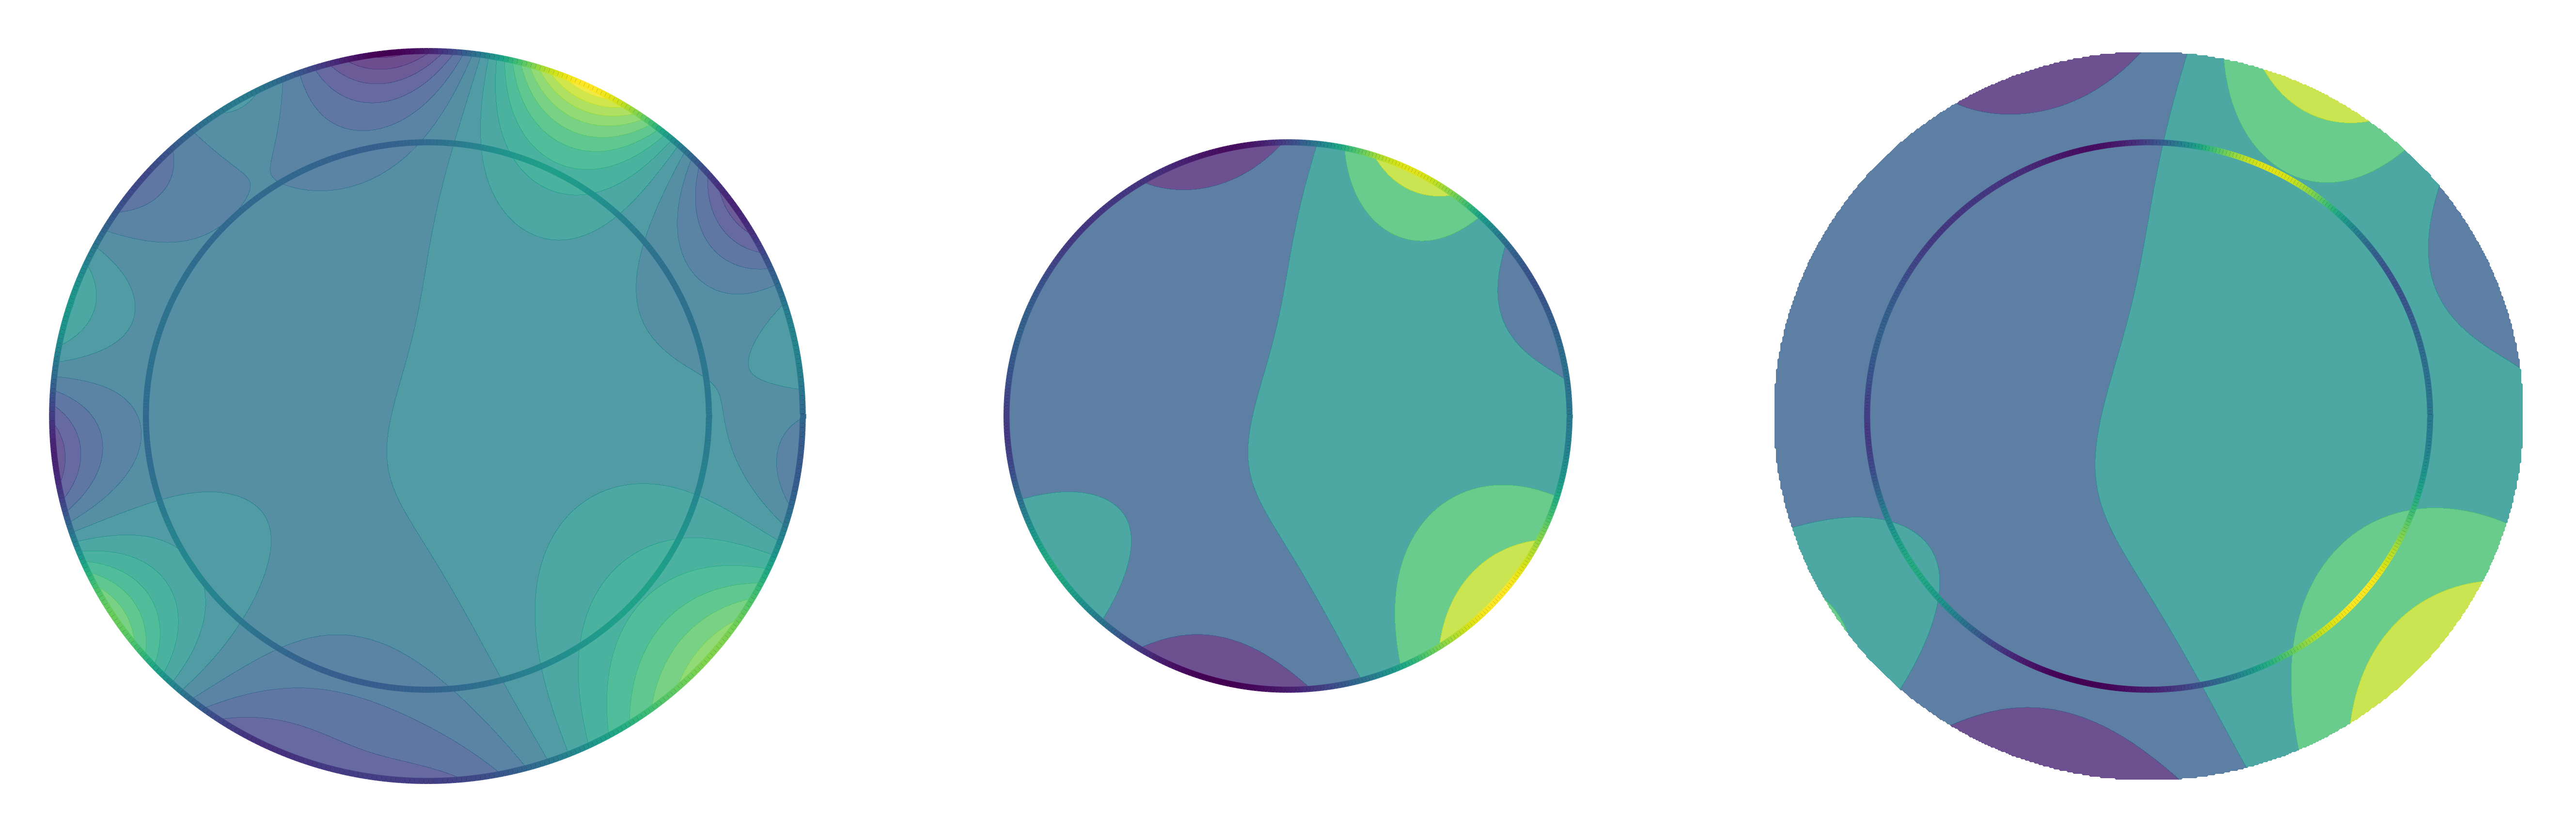

In [7]:
with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(9, 3))

    # Exterior boundary solution
    ax1 = fig.add_subplot(131)
    ax1.plot(δx, δy)
    ax1.contourf(x, y, φ, cmap="viridis", levels=20, alpha=0.8)

    points = np.array([δx, δy]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(δφ.min(), δφ.max())
    ax1.add_collection(
        LineCollection(segments, cmap="viridis", norm=norm, linewidth=1.5, array=δφ)
    )

    # Interior solution using extension mapping
    ax2 = fig.add_subplot(132)
    ax2.plot(δⁱx, δⁱy)
    ax2.contourf(x, y, φⁱ, cmap="viridis", levels=5, alpha=0.8)

    # Explicit interior solution
    ax3 = fig.add_subplot(133)
    ax3.plot(δⁱx, δⁱy)
    ax3.contourf(x, y, alt, cmap="viridis", levels=4, alpha=0.8)

    points = np.array([δⁱx, δⁱy]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    for ax in [ax1, ax2, ax3]:
        ax_norm = norm if ax == ax1 else None
        ax.add_collection(
            LineCollection(
                segments, cmap="viridis", norm=ax_norm, linewidth=1.5, array=δⁱφ
            )
        )
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()